# Analysis of Citibike trips by time

In [ ]:
%load_ext autoreload
%autoreload 2

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.ticker import FuncFormatter
import datetime as datetime
from pandas.plotting import parallel_coordinates

# import our helpers module. appending parent directory ("..") to sys.path might be necessary for helpers to be imported on some systems
import sys

sys.path.insert(0, "..")
import helpers

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Setup

In [ ]:
DATA_DIR = "../data/"
SUMMARY_DIR = DATA_DIR + "summaries/"

## Get data
* yearly summaries
* trips

In [ ]:
summaries = pd.read_parquet(SUMMARY_DIR + "summaries" + helpers.CSV_EXTENSION)
summaries

,trip_count,avg_trip_duration,mode_start_station_id,mode_start_station_count,mode_end_station_id,mode_end_station_trip_count,subscribers,customers,trips_by_males,trips_by_females
2013,5364026,900,497,53113,497,57567,4697086,666940,3590728,1105721
2014,7868282,826,521,99245,497,83706,7287687,580595,5635920,1650274
2015,8626591,815,519,96750,293,89073,8626591,0,6608883,2006962
2016,12222976,819,519,141891,519,138989,12188588,34388,9215130,2973111
2017,14718438,895,519,154466,519,153185,14407273,311165,10944297,3709823
2018,17545842,988,519,150257,519,149932,15613370,1932472,11969615,4091945
2019,20551517,978,519,156575,519,155536,17679393,2872124,14052230,4938982
2020,19506857,1311,3141,100753,426,101767,14955766,4551091,11798407,5551873
2021,1095346,934,3141,7395,3141,7282,945169,150177,714609,289850


In [ ]:
%%time
trips = helpers.get_trips(2019)

CPU times: user 30.8 s, sys: 21.7 s, total: 52.5 s
Wall time: 55.6 s


In [ ]:
trips["starttime"] = pd.to_datetime(trips["starttime"])
trips["stoptime"] = pd.to_datetime(trips["stoptime"])
trips

,tripduration,starttime,stoptime,startstationid,endstationid,bikeid,usertype,birthyear,gender
0,320,2019-01-01 00:01:47.401,2019-01-01 00:07:07.581,3160,3283,15839,Subscriber,1971,1
1,316,2019-01-01 00:04:43.736,2019-01-01 00:10:00.608,519,518,32723,Subscriber,1964,1
2,591,2019-01-01 00:06:03.997,2019-01-01 00:15:55.438,3171,3154,27451,Subscriber,1987,1
3,2719,2019-01-01 00:07:03.545,2019-01-01 00:52:22.650,504,3709,21579,Subscriber,1990,1
4,303,2019-01-01 00:07:35.945,2019-01-01 00:12:39.502,229,503,35379,Subscriber,1979,1
...,...,...,...,...,...,...,...,...,...
20551512,729,2019-10-31 23:59:12.190,2019-11-01 00:11:21.486,237,311,25725,Subscriber,1995,1
20551513,645,2019-10-31 23:59:17.047,2019-11-01 00:10:02.945,3259,461,39583,Customer,1969,0
20551514,257,2019-10-31 23:59:22.514,2019-11-01 00:03:40.260,3798,505,21240,Subscriber,1985,1
20551515,466,2019-10-31 23:59:23.171,2019-11-01 00:07:09.205,328,361,34916,Subscriber,1989,0


## Trips EDA

#### By year

In [ ]:
summaries_to_plot = (
    summaries.loc[2013:2020].reset_index().rename(columns={"index": "year"})
)

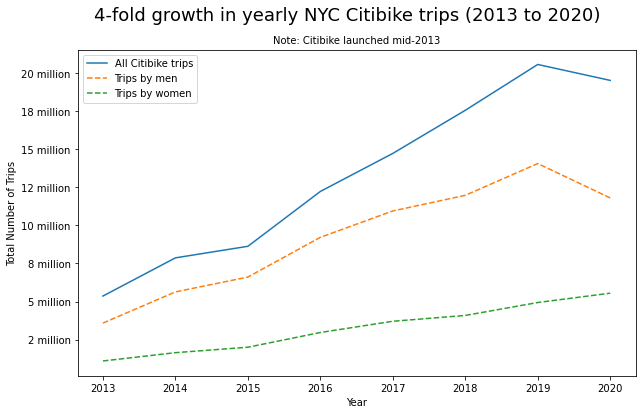

In [ ]:
# trips over years, plus gender
fig, ax = plt.subplots()
fig.set_size_inches((10, 6))
sns.lineplot(
    data=summaries_to_plot, x="year", y="trip_count", ax=ax, label="All Citibike trips"
)
sns.lineplot(
    data=summaries_to_plot,
    x="year",
    y="trips_by_males",
    ax=ax,
    label="Trips by men",
    linestyle="--",
)
sns.lineplot(
    data=summaries_to_plot,
    x="year",
    y="trips_by_females",
    ax=ax,
    label="Trips by women",
    linestyle="--",
)
plt.suptitle("4-fold growth in yearly NYC Citibike trips (2013 to 2020)", fontsize=18)
plt.title("Note: Citibike launched mid-2013", fontsize=10)
plt.xlabel("Year")
plt.ylabel("Total Number of Trips")

ax.yaxis.set_major_formatter(
    FuncFormatter(lambda x, pos: ("%1.0f million" % (x * 1e-6)))
)
plt.show()

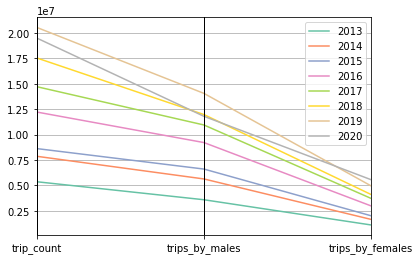

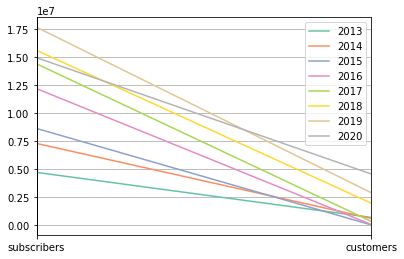

In [ ]:
# TODO toss this out. perhaps do this for gender and trips dataset?
parallel_coordinates(
    frame=summaries_to_plot[
        ["year", "trip_count", "trips_by_males", "trips_by_females"]
    ],
    class_column="year",
    colormap=plt.get_cmap("Set2"),
)
plt.show()

parallel_coordinates(
    frame=summaries_to_plot[["year", "subscribers", "customers"]],
    class_column="year",
    colormap=plt.get_cmap("Set2"),
)
plt.show()

#### By month

In [ ]:
trips_per_month = (
    trips.groupby(trips["starttime"].dt.month)["tripduration"]
    .count()
    .reset_index()
    .rename(columns={"starttime": "month", "tripduration": "counttrips"})
)
trips_per_month

,month,counttrips
0,1,967269
1,2,943735
2,3,1327950
3,4,1766094
4,5,1924563
5,6,2125370
6,7,2181010
7,8,2344135
8,9,2444900
9,10,2092573


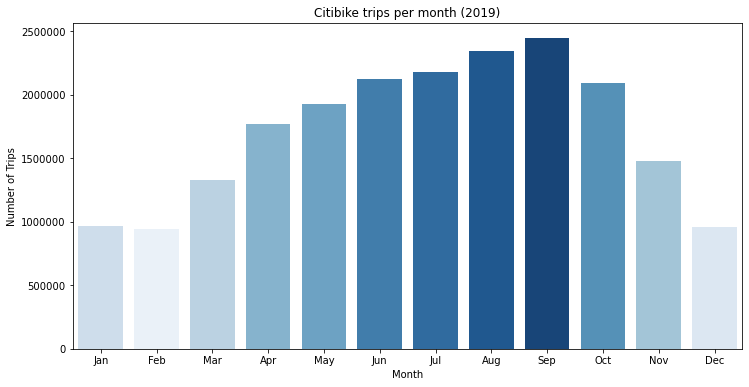

In [ ]:
# Plot trips per month
fig, ax = plt.subplots()
fig.set_size_inches(12, 6)
sns.barplot(
    data=trips_per_month,
    x="month",
    y="counttrips",
    palette=helpers.colors_from_values(trips_per_month.counttrips, "Blues"),
    ax=ax,
)
plt.title("Citibike trips per month (2019)")

# set month labels
plt.xlabel("Month")
monthlabels = [
    datetime.date(1900, month + 1, 1).strftime("%b") for month in trips_per_month.index
]
ax.set_xticks(np.arange(0, 12))
ax.set_xticklabels(monthlabels)

plt.ylabel("Number of Trips")
plt.ticklabel_format(style="plain", axis="y")
plt.show()

del trips_per_month

#### By day

In [ ]:
# trips by which day of the week it is
trips_per_day_name = (
    trips.groupby(trips["starttime"].dt.day_name())["tripduration"]
    .count()
    .reindex(
        ["Monday", "Tuesday", "Wednesday", "Thursday", "Friday", "Saturday", "Sunday"]
    )
    .reset_index()
    .rename(columns={"starttime": "day_name", "tripduration": "counttrips"})
)
trips_per_day_name

,day_name,counttrips
0,Monday,2922080
1,Tuesday,3157924
2,Wednesday,3146663
3,Thursday,3001212
4,Friday,3117804
5,Saturday,2815248
6,Sunday,2390586


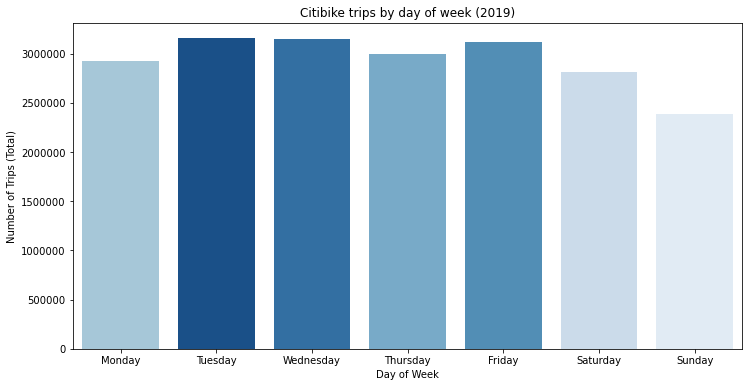

In [ ]:
# Plot trips by day of week
fig, ax = plt.subplots()
fig.set_size_inches(12, 6)
sns.barplot(
    data=trips_per_day_name,
    x="day_name",
    y="counttrips",
    palette=helpers.colors_from_values(trips_per_day_name.counttrips, "Blues"),
    ax=ax,
)
plt.title("Citibike trips by day of week (2019)")

plt.xlabel("Day of Week")
plt.ylabel("Number of Trips (Total)")
plt.ticklabel_format(style="plain", axis="y")
plt.show()

del trips_per_day_name

In [ ]:
trips_per_day = (
    trips.groupby(trips["starttime"].dt.dayofyear)["tripduration"]
    .count()
    .reset_index()
    .rename(columns={"starttime": "dayofyear", "tripduration": "counttrips"})
)
trips_per_day

,dayofyear,counttrips
0,1,21962
1,2,37797
2,3,41676
3,4,43922
4,5,17432
...,...,...
360,361,31808
361,362,28520
362,363,17968
363,364,12138


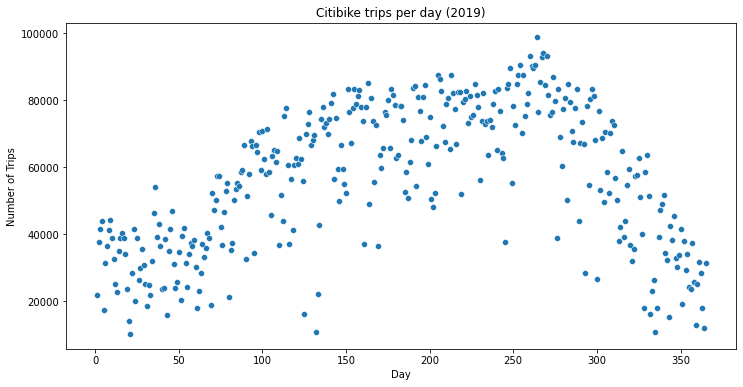

In [ ]:
# Plot trips per day
plt.figure(figsize=(12, 6))
sns.scatterplot(data=trips_per_day, x="dayofyear", y="counttrips")
plt.title("Citibike trips per day (2019)")
plt.xlabel("Day")
plt.ylabel("Number of Trips")
# TODO set xticklabels to use ConciseDateFormatter
plt.show()

del trips_per_day

#### By hour

In [ ]:
# trips by hour of day
trips_per_hour = (
    trips.groupby(trips["starttime"].dt.hour)["tripduration"]
    .count()
    .reset_index()
    .rename(columns={"starttime": "hour", "tripduration": "counttrips"})
)
trips_per_hour

,hour,counttrips
0,0,185329
1,1,105231
2,2,64300
3,3,41554
4,4,44894
5,5,139884
6,6,443042
7,7,933374
8,8,1626759
9,9,1308175


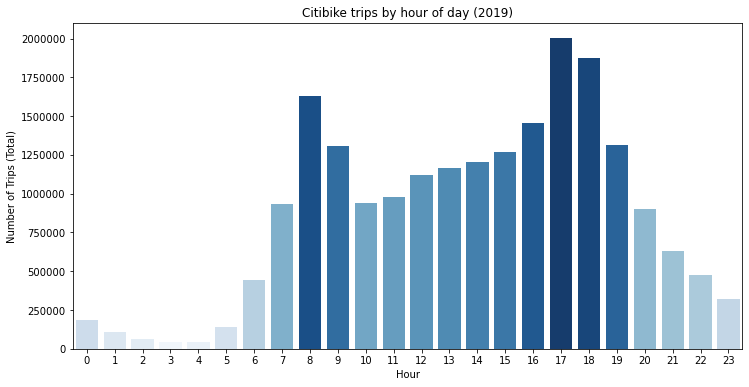

In [ ]:
# Plot trips by hour of day
fig, ax = plt.subplots()
fig.set_size_inches(12, 6)
sns.barplot(
    data=trips_per_hour,
    x="hour",
    y="counttrips",
    palette=helpers.colors_from_values(trips_per_hour.counttrips, "Blues"),
    ax=ax,
)
plt.title("Citibike trips by hour of day (2019)")

plt.xlabel("Hour")
plt.ylabel("Number of Trips (Total)")
plt.ticklabel_format(style="plain", axis="y")
plt.show()

del trips_per_hour